#                           Предсказание кассовых сборов фильмов

Для предсказания будем использовать датасет с Каггла: TMDB Box Office Prediction - https://www.kaggle.com/c/tmdb-box-office-prediction

In [191]:
%config IPCompleter.greedy=True

In [192]:
# !pip install -r requirements.txt

Заимпортим все необходимые библиотеки

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import bisect

In [194]:
import warnings

warnings.filterwarnings("ignore")

In [195]:
df = pd.read_csv("data/train.csv")

In [196]:
df

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",1596687
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",180590
2997,2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,The Long Kiss Goodnight,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",89456761
2998,2999,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www

## Часть 1: предобработка данных и подготовка к обучению

Удалим ненужные колонки: лишние id нам не нужны, как и ссылки

In [197]:
del df['id']
del df['homepage']
del df['imdb_id']
del df['original_title']
del df['poster_path']
del df['status']

Для нас не будет важно, в какой коллекции находится фильм, будет достаточно того, что он находится в *какой-то*

In [198]:
df["belongs_to_collection"].replace([np.nan, -np.inf], 0, inplace=True)
df["belongs_to_collection"] = df["belongs_to_collection"].apply(lambda x: int(isinstance(x, str)))

Заметим, что у нас много признаков находятся в строковом представлении словаря. Превратим их в нормальные словари

In [199]:
import ast

def convert_bad_features(list_of_strings) -> list[dict]:
    """Converts list of dicts in its string representation to a normal Python list of normal Python dicts."""
    if not isinstance(list_of_strings, str):
        return []
    else:
        return ast.literal_eval(list_of_strings)
    
df['genres'] = df['genres'].apply(convert_bad_features)
df['production_companies'] = df['production_companies'].apply(convert_bad_features)
df['production_countries'] = df['production_countries'].apply(convert_bad_features)
df['spoken_languages'] = df['spoken_languages'].apply(convert_bad_features)
df['Keywords'] = df['Keywords'].apply(convert_bad_features)
df['cast'] = df['cast'].apply(convert_bad_features)
df['crew'] = df['crew'].apply(convert_bad_features)

Однако из этих словарей нам нужны не все значения. 

Из жанров нам достаточно их названия, которое мы закодируем числом, а позже применим One Hot Encoding

In [200]:
df['genres'] = df['genres'].apply(lambda x: [d['name'] for d in x])

In [201]:
all_genres = sorted(list(set([g for genre_list in df['genres'] for g in genre_list])))

Таким же образум поступим с языками

In [202]:
all_languages = [lang.lower() for lang in df['original_language']]
# ещё учтём, что в колонке 'spoken_languages' есть языки, которых нет в 'original_language'
all_languages += [l['iso_639_1'].lower() for sp_lang_list in df['spoken_languages'] for l in sp_lang_list]
all_languages = sorted(list(set(all_languages)))

In [203]:
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [f"spoken_lang_{d['iso_639_1']}" for d in x])

In [204]:
df['original_language'] = df['original_language'].apply(lambda x: [f"original_language_{d}" for d in x])

Преобразуем страны производства

In [205]:
all_countries = [ctry['iso_3166_1'].upper() for ctry_list in df['production_countries'] for ctry in ctry_list]
all_countries = sorted(list(set(all_countries)))

In [206]:
df['production_countries'] = df['production_countries'].map(lambda x: [f"prod_country_{d['iso_3166_1']}" for d in x])

Даже в этом сравнительно небольшом датасете очень много разных людей в cast и crew, как и кинокомпаний. Вряд ли получится адекватно учесть все эти признаки без переобучения, поэтому уберём их совсем.

In [207]:
del df['production_companies']
del df['cast']
del df['crew']

Из даты выпуска оставим только год, так как остальное будет пренебрежимо слабо влиять на предсказание

In [208]:
def release_date_to_year(date: str):
    year = int(date[-2:])
    if year > 20: # Dataset is from 5 years ago
        return (1900 + year)
    else:
        return (2000 + year)

In [209]:
df['release_year'] = df['release_date'].apply(release_date_to_year)
del df['release_date']

Для колонки runtime нам не нужен float, потом кастанём его к int

In [210]:
df['runtime'] = df['runtime'].replace([np.nan, -np.inf, np.inf], 0).astype(int)

Заметим, что у нас есть некоторое количество фильмов без длительности

In [211]:
tmp_df = pd.DataFrame()
tmp_df['runtime'] = df['runtime']
tmp_df['title'] = df['title']
tmp_df['release_year'] = df['release_year']
tmp_df[tmp_df['runtime'] == 0]

,runtime,title,release_year
390,0,The Worst Christmas of My Life,2012
591,0,А поутру они проснулись,2003
924,0,¿Quién mató a Bambi?,2013
977,0,La peggior settimana della mia vita,2011
1255,0,"Cry, Onion!",1975
1335,0,Королёв,2007
1541,0,All at Once,2014
1874,0,Missing,2007
2150,0,Mechenosets,2006
2302,0,Happy Weekend,1996


Их не так много, поэтому дополним датасет недостающими runtime вручную

In [212]:
df['runtime'][390] = 86
df['runtime'][591] = 90
df['runtime'][924] = 86
df['runtime'][977] = 93
df['runtime'][1255] = 91
df['runtime'][1335] = 120
df['runtime'][1541] = 93
df['runtime'][1874] = 90
df['runtime'][2150] = 108
df['runtime'][2302] = 90
df['runtime'][2498] = 89
df['runtime'][2645] = 98
df['runtime'][2785] = 111
df['runtime'][2865] = 90

In [213]:
del tmp_df

Предположительно, все текстовые фичи (title, overview, tagline, keywords) влияют на кассовые сборы примерно одинаково. Сконкатенируем их, и сделаем фичу description.

*\* tagline — рекламный слоган, сопровождающий картину*

In [214]:
df['Keywords'] = df['Keywords'].apply(lambda x: ' '.join([w['name'] for w in x]))

In [215]:
df['description'] = df.agg(lambda x: f"{x['overview']}" if isinstance(x['overview'], str) else "", axis=1)
df['description'] = df.agg(lambda x: f"{x['description']} {x['tagline']}" if isinstance(x['tagline'], str) else x['description'], axis=1)
df['description'] = df.agg(lambda x: f"{x['description']} {x['Keywords']}" if isinstance(x['Keywords'], str) else x['description'], axis=1)
df['description'] = df.agg(lambda x: f"{x['description']} {x['title']}" if isinstance(x['title'], str) else x['description'], axis=1)
del df['overview']
del df['tagline']
del df['Keywords']
del df['title']

Осталось применить One Hot Encoding к колонкам genres, production_countries, spoken_languages и original_language. Для него удобнее будет превратить эти признаки в строки со значениями через запятую.

In [216]:
df['genres'] = df['genres'].apply(lambda x: ', '.join(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ', '.join(x))
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: ', '.join(x))
df['original_language'] = df['original_language'].apply(lambda x: ', '.join(x))

In [217]:
genres_ohe = df['genres'].str.get_dummies(sep=", ")
production_countries_ohe = df['production_countries'].str.get_dummies(sep=", ")
spoken_languages_ohe = df['spoken_languages'].str.get_dummies(sep=", ")
original_language_ohe = df['original_language'].str.get_dummies(sep=", ")
del df['genres']
del df['production_countries']
del df['spoken_languages']
del df['original_language']
df = pd.concat([df, genres_ohe, production_countries_ohe, spoken_languages_ohe,original_language_ohe], axis=1)

Мы будем решать задачу классификация относительно того, в какой диапозон прибыли попадёт тот или иной фильм.

In [218]:
def classify_revenue(revenue):
    return bisect.bisect_left([0, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000] , revenue)

In [219]:
df['revenue'] = df['revenue'].apply(classify_revenue)

Посмотрим на распределение классов для нашей задачи

<Axes: >

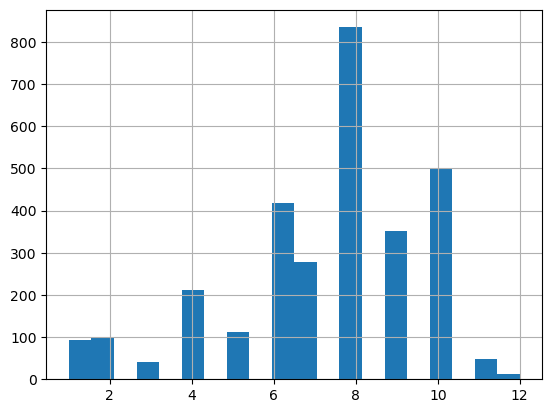

In [220]:
df['revenue'].hist(bins=20)

In [221]:
df

,belongs_to_collection,budget,popularity,runtime,revenue,release_year,description,Action,Adventure,Animation,...,original_language_m,original_language_n,original_language_o,original_language_p,original_language_r,original_language_s,original_language_t,original_language_u,original_language_v,original_language_z
0,1,14000000,6.575393,93,8,2015,"When Lou, who has become the ""father of the In...",0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,40000000,8.248895,113,9,2004,Mia Thermopolis is now a college graduate and ...,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,3300000,64.299990,105,8,2014,"Under the direction of a ruthless instructor, ...",0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1200000,3.174936,122,8,2012,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1.148070,118,6,2009,Marine Boy is the story of a former national s...,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,9.853270,102,6,1994,Military men Rock Reilly and Eddie Devane are ...,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2996,0,0,3.727996,102,4,2013,Three girls in 1980s Stockholm decide to form ...,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2997,0,65000000,14.482345,120,9,1996,"Samantha Caine, suburban homemaker, is the ide...",1,0,0,...,0,1,0,0,0,0,0,0,0,0
2998,0,42000000,15.725542,90,10,2004,Reuben Feffer is a guy who's spent his entire ...,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Готово.

Сохраним предобработанные данные в отдельный файл, чтобы использовать в следующей части

In [222]:
import pickle
import os


df.to_csv(os.path.join('data', 'preprocessed_train.csv'))

with open(os.path.join('data', 'available_values.pkl'), 'wb') as f:
    pickle.dump((all_genres, all_languages, all_countries), f)

In [223]:
# all_genres = set([g for genre_list in df['genres'] for g in genre_list])
# all_ = set([g for genre_list in df['genres'] for g in genre_list])